# Capstone project (Part 1) - IBM Data Science Professional Certificate

### For better view of folium maps displaying data points on the Toronto geographical map, go here: https://nbviewer.jupyter.org/github/VikramjitSinghRathee/IBM-Data-Science-Professional-Certificate-Capstone-Project/blob/master/Notebook-Best_Borough_Top_Recommended_Venues_Restaurants_Toronto.ipynb

## Best Borough, Top 5 Recommended venues and Top 3 Restaurants in Toronto - Recommendations for Tourists visiting Toronto (CA), using KMeans Unsupervised Machine Learning algorithm and Folium geographical maps

In [1]:
import numpy as np
import pandas as pd

### Scraping of wikipedia page, extract table data from this webpage and make Pandas dataframe.

### Beautiful Soup is a Python package for parsing HTML and XML documents. It creates a parse tree for parsed pages that can be used to extract data from HTML, which is useful for web scraping. Prettify() function in BeautifulSoup will enable us to view how the tags are nested in the document.

### Extracting data from the Toronto Postcode wiki page and making a data frame from it

In [2]:
#Requests allows you to send organic, grass-fed HTTP/1.1 requests, without the need for manual labor.
import requests
from bs4 import BeautifulSoup

#requests.get(url).text will ping a website and return you HTML of the website.
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(website_url,'lxml')
My_table = soup.find('table',{'class':'wikitable sortable'})

#all "tr" tag in a list
tag = My_table.findAll('tr') 

# extrating out data from these tags and making a pandas dataframe from it
pst_list = []
count = 1

while count <= (len(tag)-1):
    
    pst_code = tag[count].findAll('td')[0].get_text()
    brgh = tag[count].findAll('td')[1].get_text()
    neigh = tag[count].findAll('td')[2].get_text()
    
    pst_list.append([pst_code,brgh,neigh.strip()])
    count = count+1
    
df = pd.DataFrame(pst_list)
df.columns = ['Postcode', 'Borough', 'Neighbourhood']

# Ignore cells with a borough that is Not assigned.
df = df[df['Borough'] != "Not assigned"].reset_index(drop=True)

# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
mask = (df['Neighbourhood'] == "Not assigned")
idx = df[mask].index.values.astype(int)[0]               # Since there is only one entry
df.iloc[idx]['Neighbourhood'] = df.iloc[idx]['Borough']

# More than one neighborhood can exist in one postal code area, hence we are joining them by for those postcodes
df = df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()

# To confirm neighbourhoods belonging to single postcode are all collected, print out some samples
print("Sample rows showing collection of neighbourhoods under Postcode")
display(df[(df['Postcode'] == 'M4B') | (df['Postcode'] == 'M1R') | (df['Postcode'] == 'M5A') | (df['Postcode'] == 'M1B')])

# Final dataframe
print("\n")
print("Below is the FINAL scraped dataframe of shape "+str(df.shape))
display(df.head())

Sample rows showing collection of neighbourhoods under Postcode


,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
11,M1R,Scarborough,"Maryvale, Wexford"
35,M4B,East York,"Woodbine Gardens, Parkview Hill"
53,M5A,Downtown Toronto,Harbourfront




Below is the FINAL scraped dataframe of shape (103, 3)


,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Loading geographical coordinates for the Toronto Postcodes and appending to the dataframe

In [3]:
df_cords = pd.read_csv("Geospatial_Coordinates.csv").drop(columns=['Postal Code'])
df['Latitude'] = df_cords['Latitude']
df['Longitude'] = df_cords['Longitude']
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Checking if correct coordinates are loaded

In [4]:
print("Sample rows showing Postcode coordinates")
display(df[(df['Postcode'] == 'M5G') | (df['Postcode'] == 'M2H') | (df['Postcode'] == 'M4B') | (df['Postcode'] == 'M1J')])

Sample rows showing Postcode coordinates


,Postcode,Borough,Neighbourhood,Latitude,Longitude
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
17,M2H,North York,Hillcrest Village,43.803762,-79.363452
35,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
57,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383


### Displaying Neighbourhoods and Postcodes for Toronto

In [5]:
# Unique Boroughs in the dataset
print("Unique Boroughs in the dataframe\n")
print(df["Borough"].unique())

# Boroughs in the Toronto
print("")
print("")
print("Boroughs in Toronto")
df_toto = df[df['Borough'].str.contains("Toronto")].reset_index(drop=True)

print("shape of Toronto dataframe is "+str(df_toto.shape))
df_toto.head()

Unique Boroughs in the dataframe

['Scarborough' 'North York' 'East York' 'East Toronto' 'Central Toronto'
 'Downtown Toronto' 'York' 'West Toronto' "Queen's Park" 'Mississauga'
 'Etobicoke']


Boroughs in Toronto
shape of Toronto dataframe is (38, 5)


,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


### Import relevant libraries for data analysis

In [6]:
import json # library to handle JSON files

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

print('Libraries imported.')

Libraries imported.


### obtaining Latitude and Longitude of Toronto using geopy python library

In [7]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
toto_latitude = location.latitude
toto_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(toto_latitude, toto_longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Create map of Toronto using Folium and plotting Postcode coodinates. Label of each point gives info about the Postcode and the Borough

In [8]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[toto_latitude, toto_longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, postcode in zip(df_toto['Latitude'], df_toto['Longitude'], df_toto['Borough'], df_toto['Postcode']):
    label = '{}, {}'.format(postcode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### We can cluster these points via KMeans Clustering algorithm using the sklearn library

In [9]:
# Using Unsupervised ML algorithm - KMeans, group the postcodes into 4 differernt clusters based on proximity

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=30).fit(df_toto[['Latitude','Longitude']])
df_toto["Cluster"] = kmeans.predict(df_toto[['Latitude','Longitude']])

print(kmeans.cluster_centers_)

df_toto.head()

[[ 43.658162   -79.36771749]
 [ 43.67977494 -79.42036114]]


,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1


### Displaying clusters obtained from KMeans on the map of Toronto. Pink pinpoint marker represents the Toronto Center coordinates. Red points indicate Postcodes belonging to Cluster 0 and Blue points indicate same for Cluster 1. Red and Blue pinpoint markers represents the center of these clusters obtained from KMeans

In [10]:
# create map of Toronto using latitude and longitude values
new_map_toronto = folium.Map(location=[toto_latitude, toto_longitude], zoom_start=11)

# add colored markers corresponding to different clusters
for lat, lng, borough, postcode, cluster in zip(df_toto['Latitude'], df_toto['Longitude'], df_toto['Borough'], df_toto['Postcode'], df_toto['Cluster']):
    label = '{}, {}'.format(postcode, borough)
    label = folium.Popup(label, parse_html=True)
    if cluster == 0:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=1,
            parse_html=False).add_to(new_map_toronto)
    if cluster == 1:
            folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=1,
            parse_html=False).add_to(new_map_toronto)

tooltip = 'Click me!'

folium.Marker([kmeans.cluster_centers_[0][0], kmeans.cluster_centers_[0][1]], icon=folium.Icon(color='red'), popup='<b>Postcode Cluster 0</b>').add_to(new_map_toronto)
folium.Marker([kmeans.cluster_centers_[1][0], kmeans.cluster_centers_[1][1]], icon=folium.Icon(color='blue'), popup='<b>Postcode Cluster 1</b>').add_to(new_map_toronto)
folium.Marker([toto_latitude, toto_longitude], icon=folium.Icon(color='pink'), popup='<b>Toronto Center</b>').add_to(new_map_toronto)


new_map_toronto

### Define function to calculate distance given coordinates using geopy library

In [11]:
# pip install geopy
# Importing the geodesic module from the library 

from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')

def dist(lat,long,center):
    dist = geodesic((lat,long), center).meters
    return dist

### Created separate dataframe for each cluster and calculated mean distance of data points in each cluster to the center of that cluster

In [12]:
# Make separate dataframes for each cluster
df_cluster0 = df_toto[df_toto["Cluster"] == 0]
df_cluster1 = df_toto[df_toto["Cluster"] == 1]

cluster0_center = (kmeans.cluster_centers_[0][0], kmeans.cluster_centers_[0][1])
cluster1_center = (kmeans.cluster_centers_[1][0], kmeans.cluster_centers_[1][1])

df_cluster0['Dist. from Center in meters'] = df_cluster0.apply(lambda x: dist(x['Latitude'],x['Longitude'],cluster0_center),axis=1)
df_cluster1['Dist. from Center in meters'] = df_cluster1.apply(lambda x: dist(x['Latitude'],x['Longitude'],cluster1_center),axis=1)

mean_clus0_dist = round(df_cluster0['Dist. from Center in meters'].mean())
mean_clus1_dist = round(df_cluster1['Dist. from Center in meters'].mean())

print("mean distance (m) from center in Cluster 0 is: "+ str(mean_clus0_dist))
print("mean distance (m) from center in Cluster 1 is: "+ str(mean_clus1_dist))

mean distance (m) from center in Cluster 0 is: 2293
mean distance (m) from center in Cluster 1 is: 3487


### Define Foursquare Credentials and Version using credentials saved in a .json file

In [13]:
with open('../credentials.json') as f:
    data = json.load(f)
    CLIENT_ID = data['clientID']
    CLIENT_SECRET = data['clientSecret']
    VERSION = data['version']

### Define methods that will generate foursquare API endpoint URL to extract venue information from foursquare database.
   1. ven_exp_url provides URL for exploring the recommended venues around a given latitude and longitude values
   2. likes_ven_url provides URL which gives number of likes given by people for a particular venue.
   3. get_category_type extracts the category of the venue after the json response has been obtained using API
   4. get_df returns a dataframe after extrating venue attributes from the json response obtained using the API.

In [14]:
# ven_exp_url provides url for exploring the recommended venues around a given latitude and longitude values
def ven_exp_url(lat,long,radius,limit):
    #create URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        limit)
    return url



# likes_ven_url provides url which gives number of likes given by people for a particular venue.
def likes_ven_url(venue_id):
    #create URL
    url = 'https://api.foursquare.com/v2/venues/'+venue_id+'/likes?&client_id={}&client_secret={}&v={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    return url



# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    

# get_df returns a dataframe after extrating venue attributes from the json response obtained using the API.    
def get_df(nearby_venues):
    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.id', 'venue.location.postalCode']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    df_ven_ = nearby_venues
    
    return df_ven_

### Sending the explore URL request to explore Recommended venues around Toronto and creating a dataframe from it. 

In [15]:
lat = toto_latitude
long = toto_longitude
radius = 100000
limit = 500

exp_url = ven_exp_url(lat,long,radius,limit)
exp_results = requests.get(exp_url).json()

exp_venues = exp_results['response']['groups'][0]['items']
nearby_venues = json_normalize(exp_venues) # flatten JSON

df_ven_ = get_df(nearby_venues)

display(df_ven_.head())
print(df_ven_.shape)

,name,categories,lat,lng,id,postalCode
0,Woodbine Beach,Beach,43.663112,-79.306374,4ada281ef964a520441f21e3,M4L 3W6
1,Left Field Brewery,Brewery,43.673705,-79.330310,52ec057a11d23d4bcd3e74e7,M4L 3W9
2,Black Lab Brewing,Brewery,43.661839,-79.329137,5b3af4f125fb7b0039f9f588,M4L 1A1
3,Riverdale Park East,Park,43.669951,-79.355493,4ba5a1e2f964a5202b1839e3,M4K 2P1
4,Merchants of Green Coffee,Coffee Shop,43.659916,-79.353963,502652fee4b0e6861eab1f29,NaN


(100, 6)


### Let's check the Boroughs that reside in Cluster 0 and compare them via bar graph. It seems that most of the Recommended  venues are in Downtown Toronto

Contribution of boroughs to Cluster 0 (Most of the recommended venues by fourspace API reside in Cluster 0 )


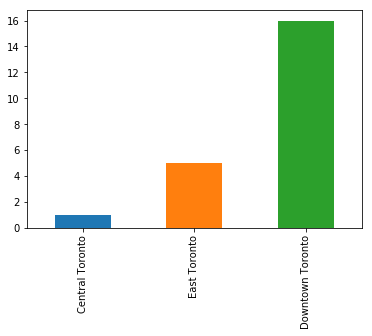

In [20]:
df_cluster0['Borough'].value_counts().sort_values().plot(kind = 'bar')
print("Contribution of boroughs to Cluster 0 (Most of the recommended venues by fourspace API reside in Cluster 0 )")

### We find out the Top Recommended venues on the basis of number of likes for these Top 100 venues. We obtain number likes via sending the URL request to the Foursquare API to get the number of 'likes' stored in the database for each venue.
1. First plotting Top 100 Recommended venues on the Toronto map. We see that the top 100 Recommended venues are largely clustered in Cluster 0. Green circles represent the Recommended venues
2. Then let's check which Borough the Top 5 Recommended venues reside in?? and also the Top 3 Restaurants??

In [17]:
df_ven_['likes'] = df_ven_.apply(lambda x: requests.get(likes_ven_url(x['id'])).json()['response']['likes']['count'],axis=1)
df_top_5 = df_ven_.sort_values(by=['likes'],ascending=False).head()
df_top_3_restrnts = df_ven_[df_ven_['categories'].str.contains("Restaurant")].sort_values(by=['likes'],ascending=False)[:3]
display(df_top_5)
display(df_top_3_restrnts)

for lati, lngi, name, category, likes in zip(df_ven_['lat'], df_ven_['lng'], df_ven_['name'], df_ven_['categories'],df_ven_['likes']):
    label = '{}, {}, # of likes: {}'.format(name, category, likes)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lati, lngi],
        radius=2,
        popup=label,
        color='green',
        fill=False,
        parse_html=False).add_to(new_map_toronto)
    
new_map_toronto

,name,categories,lat,lng,id,postalCode,likes
53,CN Tower,Monument / Landmark,43.642536,-79.387182,4ad4c05ef964a52096f620e3,M5V 2T6,1991
71,Royal Ontario Museum,Museum,43.668367,-79.394813,4ad4c05ef964a520d9f620e3,M5S 2C6,1489
36,Art Gallery of Ontario,Art Gallery,43.654003,-79.392922,4ad4c05ef964a520daf620e3,M5T 1G4,1314
9,St. Lawrence Market (South Building),Farmers Market,43.648743,-79.371597,4ad4c062f964a520fbf720e3,M5E 1C3,1263
45,TIFF Bell Lightbox,Movie Theater,43.646342,-79.390063,4bcf714ab221c9b67f0ad2d0,M5V 3X5,780


,name,categories,lat,lng,id,postalCode,likes
21,Pai,Thai Restaurant,43.647923,-79.388579,529612de11d2ab526191ccc9,M5H 3G6,668
96,Gusto 101,Italian Restaurant,43.644988,-79.400270,4ee8f32602d5895bd7dce1b1,M5V 2N3,407
67,Seven Lives - Tacos y Mariscos,Mexican Restaurant,43.654418,-79.400545,50427a03e4b08d9f5931f593,M5T 2L6,298


### It seems both Top 5 Recommended venues and Top 3 restaurants both lie in the M5 Borough. This is code for the Downtown Toronto. Hence Best Recommneded venues and restaurants lie in Downtown Toronto!!

### Below we plot these Top 5 Recommended venues (Yellow hollow rings) and the Top 3 restaurant (Orange hollow rings) on the Toronto map.

In [18]:
for lati, lngi, name, category, likes in zip(df_top_5['lat'], df_top_5['lng'], df_top_5['name'], df_top_5['categories'],df_top_5['likes']):
    label = '</b>{}, {}, # of likes: {}</b>'.format(name, category, likes)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lati, lngi],
        radius=5,
        popup=label,
        color='yellow',
        fill=False,
        parse_html=False).add_to(new_map_toronto)

    
for lati, lngi, name, category, likes in zip(df_top_3_restrnts['lat'],df_top_3_restrnts['lng'], df_top_3_restrnts['name'], df_top_3_restrnts['categories'],df_top_3_restrnts['likes']):
    label = '</b>{}, {}, # of likes: {}</b>'.format(name, category, likes)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lati, lngi],
        radius=5,
        popup=label,
        color='orange',
        fill=False,
        parse_html=False).add_to(new_map_toronto)
    
new_map_toronto

### Conclusion: Based on this Clustering analysis, Downtown Toronto Borough should be given as the recommendation for the best venues and the best restaurants to the visiting tourists. Below are the Top 5 Recommended venues and Top 3 Restaurants

In [19]:
display(df_top_5[['name', 'categories']].reset_index(drop=True))
display(df_top_3_restrnts [['name', 'categories']].reset_index(drop=True))

,name,categories
0,CN Tower,Monument / Landmark
1,Royal Ontario Museum,Museum
2,Art Gallery of Ontario,Art Gallery
3,St. Lawrence Market (South Building),Farmers Market
4,TIFF Bell Lightbox,Movie Theater


,name,categories
0,Pai,Thai Restaurant
1,Gusto 101,Italian Restaurant
2,Seven Lives - Tacos y Mariscos,Mexican Restaurant
